In [32]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.datasets import make_moons
import torch.optim as optim


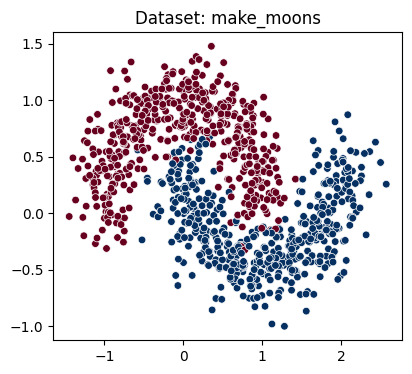

In [33]:
# noise: standard deviation of Gaussian noise added to the data
X, y = make_moons(
    n_samples=1000,
    noise=0.20,
    random_state=42
)

plt.figure(figsize=(4.5, 4))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='RdBu', s=30, edgecolor='white', linewidth=0.5)
plt.title('Dataset: make_moons')
plt.show()

In [34]:
idx = np.arange(len(X))
np.random.shuffle(idx)
split = int(len(X) * 0.8)
train_idx = idx[:split]
val_idx = idx[split:]
X_train,y_train = X[train_idx],y[train_idx]
X_val,y_val = X[val_idx],y[val_idx]

In [47]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

device(type='mps')

In [36]:
X_train_t = torch.from_numpy(X_train).float().to(device)
y_train_t = torch.from_numpy(y_train).float().unsqueeze(1).to(device)
X_val_t = torch.from_numpy(X_val).float().to(device)
y_val_t = torch.from_numpy(y_val).float().unsqueeze(1).to(device)

In [37]:
def build_mlp(input_dim, hidden_dim, num_hidden_layers, activation_fn, output_dim=1):
    layers = []
    
    # Input layer
    layers.append(nn.Linear(input_dim, hidden_dim))
    layers.append(activation_fn())

    # Hidden layers
    for _ in range(num_hidden_layers - 1):
        layers.append(nn.Linear(hidden_dim, hidden_dim))
        layers.append(activation_fn())

    # Output layer
    layers.append(nn.Linear(hidden_dim, output_dim))
    layers.append(nn.Sigmoid())   # binary classification
    
    return nn.Sequential(*layers)


In [38]:
def train_and_evaluate(model_arch, lr, num_epochs):
    model = model_arch.to(device)
    
    loss_fn = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        y_pred = model(X_train_t)
        loss = loss_fn(y_pred, y_train_t)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())

        model.eval()
        with torch.no_grad():
            val_pred = model(X_val_t)
            val_loss = loss_fn(val_pred, y_val_t)
            val_losses.append(val_loss.item())
            
            val_predicted_classes = (val_pred >= 0.5).float()
            val_accuracy = (val_predicted_classes == y_val_t).sum().item() / len(y_val_t)
            val_accuracies.append(val_accuracy)

    final_accuracy = val_accuracies[-1]
    return train_losses, val_losses, final_accuracy, model


In [39]:
def plot_results(model, X, y, best_result, best_lr, device, steps=300, cmap='RdBu'):
    """
    Plots decision boundary + loss curves in one combined figure.
    """

    model.to(device)
    model.eval()

    # === 1. Create mesh grid ===
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, steps),
        np.linspace(y_min, y_max, steps)
    )

    # Prepare grid for prediction
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_t = torch.from_numpy(grid).float().to(device)

    with torch.no_grad():
        preds = model(grid_t).cpu().numpy().reshape(xx.shape)

    # === 2. Create combined figure ===
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # -------- LEFT: Decision Boundary --------
    axs[0].contourf(xx, yy, preds, levels=50, cmap=cmap, alpha=0.6)
    axs[0].scatter(
        X[:, 0], X[:, 1], c=y, cmap=cmap, s=30,
        edgecolor='white', linewidth=0.5
    )
    axs[0].set_title("Decision Boundary")
    axs[0].set_xlabel("x1")
    axs[0].set_ylabel("x2")

    # -------- RIGHT: Loss Curves --------
    axs[1].plot(best_result['train_loss'], label='Training Loss', color='blue')
    axs[1].plot(best_result['val_loss'], label='Validation Loss', color='red')
    axs[1].set_title(f'Loss Curves (LR: {best_lr})')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('BCE Loss')
    axs[1].grid(True, linestyle='--', alpha=0.6)
    axs[1].legend()

    plt.tight_layout()
    plt.show()


In [40]:
def hyperparameter_tuning(
    learning_rates,
    num_epochs,
    num_hidden_layers,
    hidden_dim,
    activation_fn
):
    results = {}
    best_accuracy = 0
    best_lr = None
    best_model = None

    print("Starting Hyperparameter Tuning...")

    for lr in learning_rates:
        print(f"\nTraining with Learning Rate (LR): {lr}")

        # Build model automatically
        model_arch = build_mlp(
            input_dim=2,
            hidden_dim=hidden_dim,
            num_hidden_layers=num_hidden_layers,
            activation_fn=activation_fn,
        )

        train_loss, val_loss, final_acc, trained_model = train_and_evaluate(
            model_arch, lr, num_epochs)

        results[lr] = {
            'train_loss': train_loss,
            'val_loss': val_loss,
            'accuracy': final_acc
        }

        if final_acc > best_accuracy:
            best_accuracy = final_acc
            best_lr = lr
            best_model = trained_model

    print("\n--- Tuning Summary ---")
    print(f"Best Accuracy: {best_accuracy:.4f} achieved with LR: {best_lr}")

    return best_model, best_lr, best_accuracy, results


In [46]:
activation_fn = nn.ReLU
num_hidden_layers = 10
hidden_dim = 4
learning_rates = [1e-3, 2e-3, 3e-3]
num_epochs = 200

best_model, best_lr, best_acc, results = hyperparameter_tuning(
    learning_rates=learning_rates,
    num_epochs=num_epochs,
    num_hidden_layers=num_hidden_layers,      # You control architecture depth
    hidden_dim=hidden_dim,             # Neurons per layer
    activation_fn=activation_fn    # Pass activation here
)

Starting Hyperparameter Tuning...

Training with Learning Rate (LR): 0.001

Training with Learning Rate (LR): 0.002

Training with Learning Rate (LR): 0.003

--- Tuning Summary ---
Best Accuracy: 0.9450 achieved with LR: 0.002


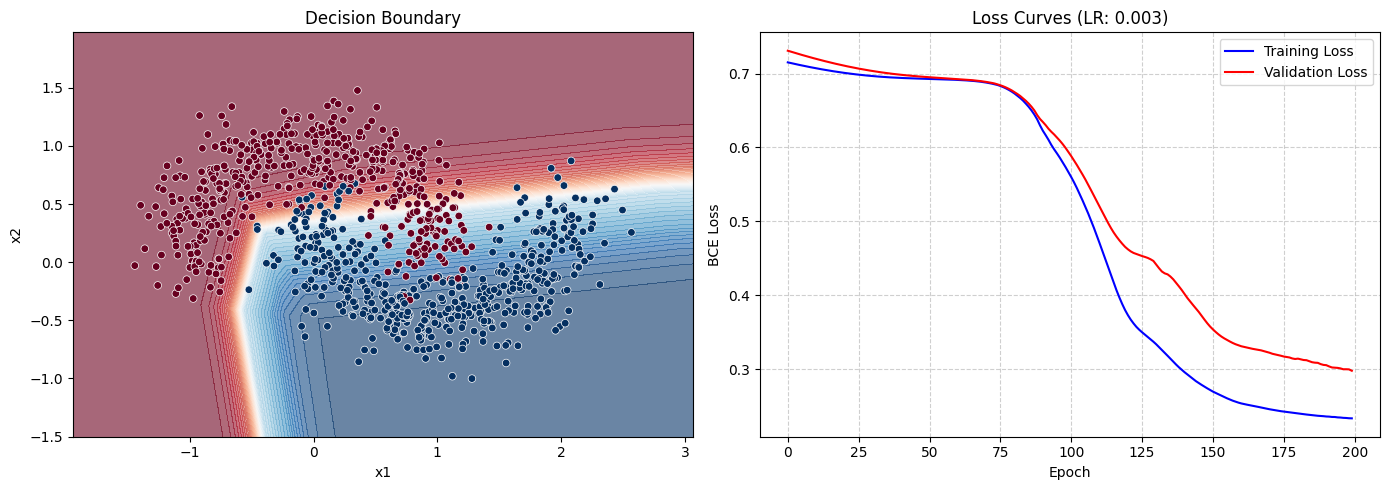

In [42]:
plot_results(best_model, X, y,results[best_lr],best_lr,device=device)

Starting Hyperparameter Tuning...

Training with Learning Rate (LR): 0.0001

Training with Learning Rate (LR): 0.0003

Training with Learning Rate (LR): 0.001

--- Tuning Summary ---
Best Accuracy: 0.9800 achieved with LR: 0.001


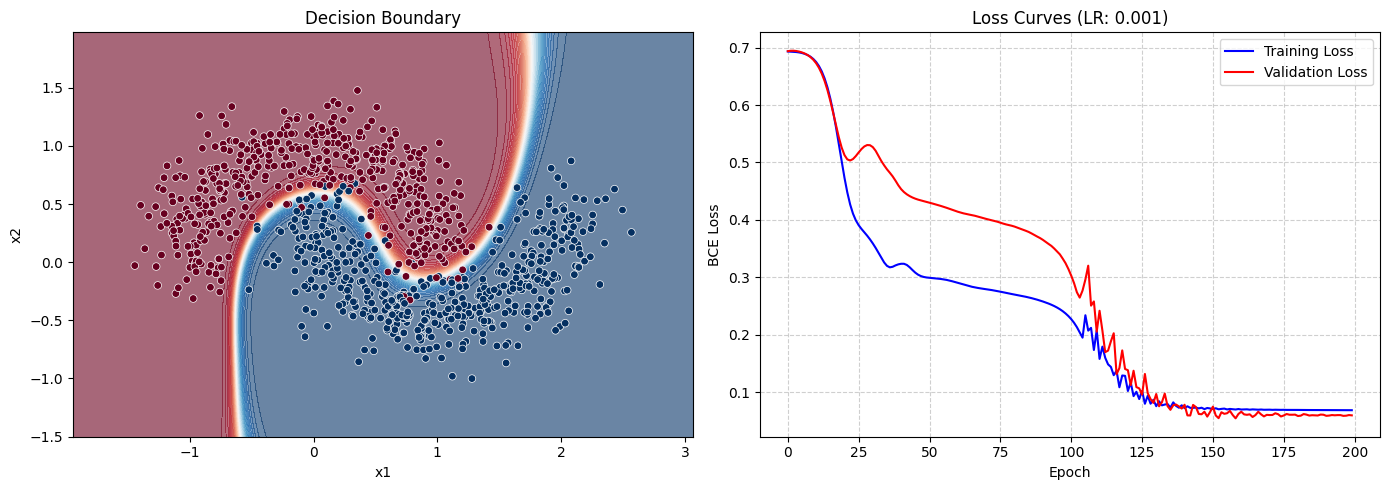

In [43]:
activation_fn = nn.Tanh
num_hidden_layers = 12
hidden_dim = 32
learning_rates = [1e-4, 3e-4, 1e-3]
num_epochs = 200

best_model, best_lr, best_acc, results = hyperparameter_tuning(
    learning_rates=learning_rates,
    num_epochs=num_epochs,
    num_hidden_layers=num_hidden_layers,      # You control architecture depth
    hidden_dim=hidden_dim,             # Neurons per layer
    activation_fn=activation_fn    # Pass activation here
)

plot_results(best_model, X, y,results[best_lr],best_lr,device=device)

Starting Hyperparameter Tuning...

Training with Learning Rate (LR): 0.01

Training with Learning Rate (LR): 0.03

Training with Learning Rate (LR): 0.0001

--- Tuning Summary ---
Best Accuracy: 0.9750 achieved with LR: 0.03


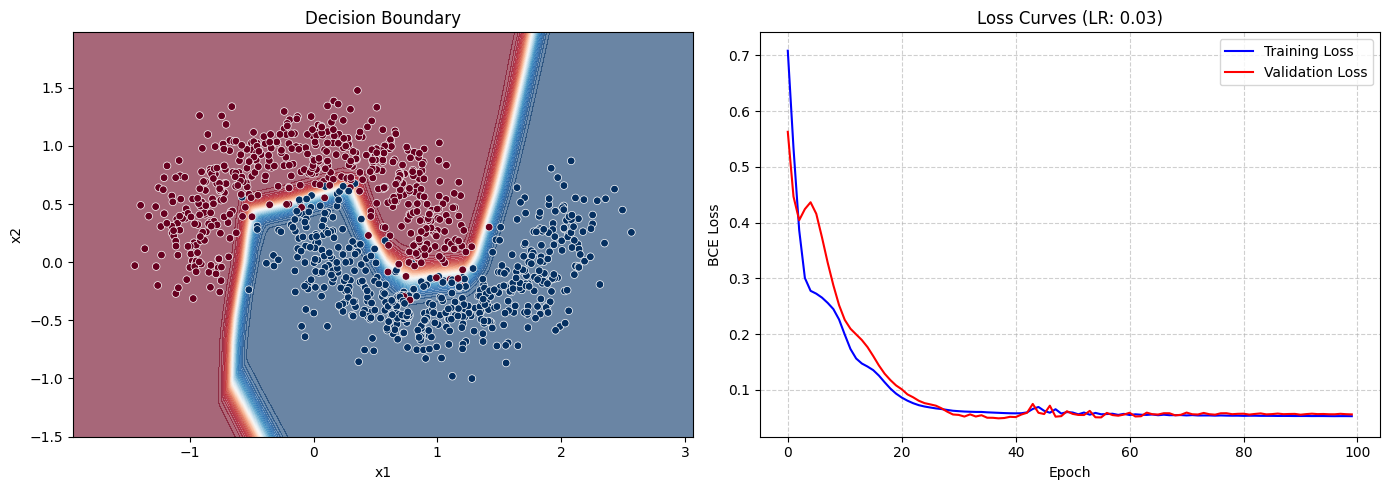

In [44]:
activation_fn = nn.ReLU
num_hidden_layers = 2
hidden_dim = 64
learning_rates = [1e-2, 3e-2, 1e-4]
num_epochs = 100

best_model, best_lr, best_acc, results = hyperparameter_tuning(
    learning_rates=learning_rates,
    num_epochs=num_epochs,
    num_hidden_layers=num_hidden_layers,      # You control architecture depth
    hidden_dim=hidden_dim,             # Neurons per layer
    activation_fn=activation_fn    # Pass activation here
)

plot_results(best_model, X, y,results[best_lr],best_lr,device=device)